# Simulador regat de la gespa

En aquesta pràctica simularem el sistema de regat de la gespa d'un camp de futbol. El nostre sistema de regat està format per un sensor de temperatura i un sensor d'humitat del terreny.

Segons els valors d'aquests sensors, el sistema de regat decidirà si ha d'activar o no l'aspersor i amb quina intensitat. L'objectiu es mantindre la humitat del terreny entre el 20% i el 25%.

## Variables físiques del sistema

En primer lloc, definirem el funcionament de les variables físiques del sistema.  Per simplificar el problema, considerarem que la temperatura vindrà definida per una funció sinusoidal. 

La funció python que defineix la temperatura és la següent:

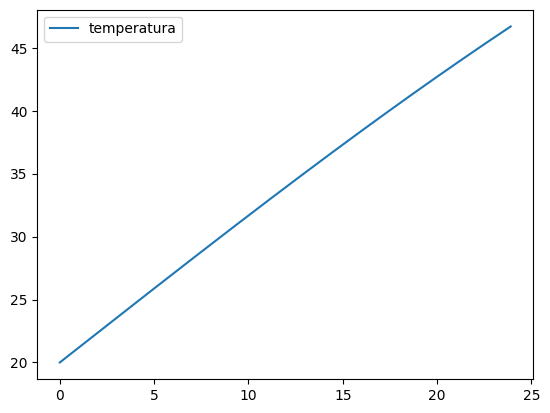

In [201]:
import numpy as np

def calc_temperatura(t):
    return 20 + 50 * np.sin(1.5 * np.pi * t / 200)

# Grafiquem la funció

import matplotlib.pyplot as plt

t = np.arange(0, 24, 0.1)
plt.plot(t, calc_temperatura(t), label='temperatura')
plt.legend()
plt.show()

La humitat del terreny, començarà del 20% i anirà augmentant o disminuint en funció de la temperatura i de si s'activa o no l'aspersor. La funció python que defineix la humitat del terreny és la següent:

In [202]:
def humitat_terreny(h_actual=20, temperatura=20, aspersor=0):
    h = h_actual + 0.1 * (aspersor - 50) + 0.1 * (temperatura - 20) / 30
    return h

# Grafiquem la funció

#t = np.arange(0, 24, 0.1)
#plt.plot(t, humitat_terreny(20, 10), label='humitat terreny')
#plt.legend()
#plt.show()

## Definició del sistema de regat simple

En aquest apartat, definirem un controlador simple per al sistema de regat. Aquest controlador activarà l'aspersor quan la humitat del terreny sigui inferior al 20% i desactivarà l'aspersor quan la humitat del terreny sigui superior al 25%. En cas contrari, el controlador mantindrà l'aspersor amb una intensitat proporcional a la humitat del terreny.

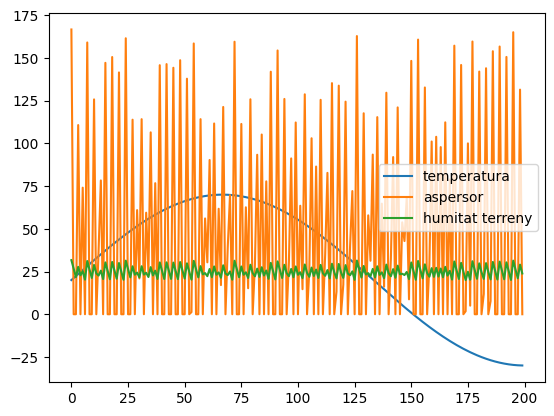

In [203]:
def controlador_simple(humitat_terreny_actual,  temperatura=20):
    if humitat_terreny_actual < 20:
        return 100
    elif humitat_terreny_actual > 25:
        return 0
    else:
        return (25 - humitat_terreny_actual) * 100 / 3
        
def simula_regat(cnt, humitat_terreny_actual=20, t_final=100):
    # Definim els vectors de temps i de valors de les variables
    temperatures = []
    humitats_terreny = []
    aspersors = []
    for i in range(t_final):
        temp = calc_temperatura(i)
        temperatures.append(temp)

        aspersor = cnt(humitat_terreny_actual, temp)
        aspersors.append(aspersor)
        
        humitat_terreny_actual = humitat_terreny(h_actual=humitat_terreny_actual, temperatura=temp, aspersor=aspersor)
        humitats_terreny.append(humitat_terreny_actual)
        
    # Grafiquem els resultats
    plt.plot(temperatures, label='temperatura')
    plt.plot(aspersors, label='aspersor')
    plt.plot(humitats_terreny, label='humitat terreny')
    plt.legend()

simula_regat(controlador_simple, 20, 200)    

## Controlador difús

En aquest apartat, definirem un controlador difús per al sistema de regat.

Per a la implementació del controlador, utilitzarem la llibreria [scikit-fuzzy](https://pythonhosted.org/scikit-fuzzy/). Aquesta llibreria ens permetrà definir les funcions d'adhesió i les regles difuses de forma senzilla.

Començarem important les llibreries necessàries:

In [204]:
#%pip install scikit-fuzzy
# Importem les llibreries necessàries

import skfuzzy as fuzz
from skfuzzy import control as ctrl

## Definició dels antecedents i dels consequents

En primer lloc, definirem els antecedents i els consequents del sistema de regat. Els antecedents són els sensors de temperatura i humitat del terreny. Els consequents són els valors de l'aspersor.

In [205]:
# Definim els antecedents i els consequents

# Antecedents

# Temperatura
temperatura = ctrl.Antecedent(np.arange(-10, 101, 1), 'temperatura (ºC)')

# Humitat del terreny
humitat = ctrl.Antecedent(np.arange(0, 101, 1), 'humitat terreny (%)')

# Consequents

# Aspersor
aspersor = ctrl.Consequent(np.arange(0, 101, 1), 'aspersor (%)')

## Definició de les funcions d'adhesió

A continuació, definirem les funcions d'adhesió dels antecedents i dels consequents. Per a cada antecedent i per a cada consequent, definirem les funcions d'adhesió que considerem necessàries. En aquest cas, definirem les funcions d'adhesió triangulars.

Per a definir les funcions d'adhesió, utilitzarem la funció `trimf` de la llibreria `skfuzzy`. Aquesta funció rep com a paràmetre un vector amb els punts de la funció d'adhesió. En el nostre cas, definirem funcions d'adhesió triangulars.

Per a definir els punts de les funcions d'adhesió, ens basarem en els criteris de la taula següent:

| Antecedent  | Punts funció d'adhesió                                                                                  |
|-------------|---------------------------------------------------------------------------------------------------------|
| Humitat     | Sec: 0, 0, 17<br>Apropiat: 15, 20, 25<br>Mullat: 23, 50, 100                                            |
| Temperatura | Fred: -10, 0, 15<br>Normal: 12, 20, 28<br>Calor: 24, 31.5, 39<br>Molta calor: 35, 65.5, 100             |
| Aspersor    | Molt poc: -20, 0, 20<br>Poc: 15, 30, 45<br>Mitja: 40, 55, 70<br>Molt: 65, 75, 85<br>Total: 80, 100, 120 |



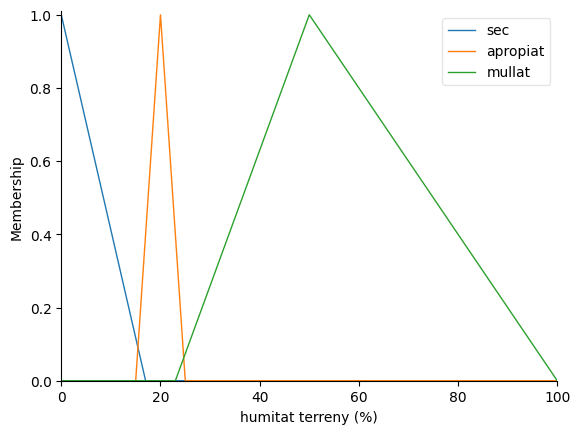

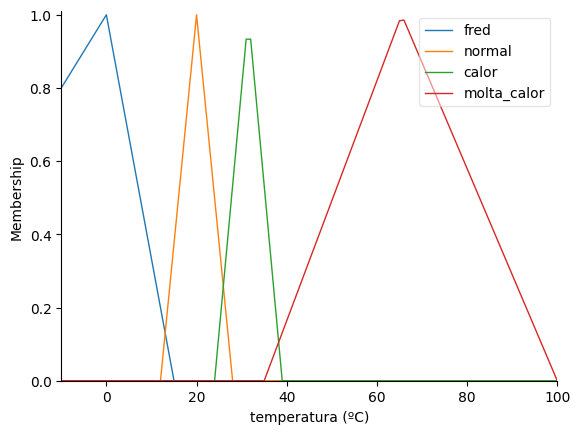

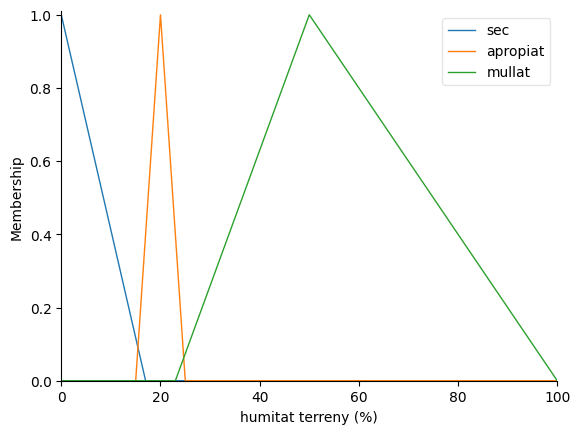

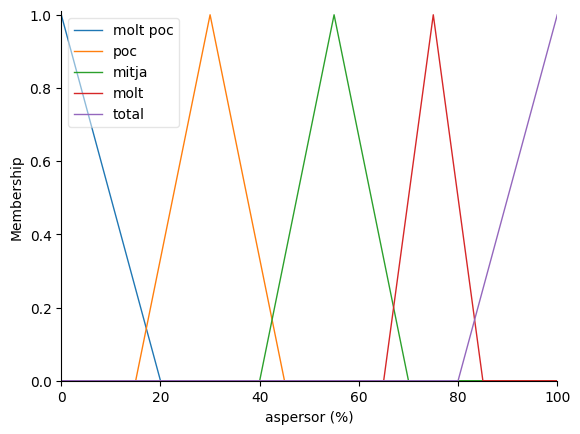

In [206]:
# Definim les funcions d'adhesió dels antecedents i dels consequents

# Humitat terreny
humitat['sec'] = fuzz.trimf(humitat.universe, [0, 0, 17])
humitat['apropiat'] = fuzz.trimf(humitat.universe, [15, 20, 25])
humitat['mullat'] = fuzz.trimf(humitat.universe, [23, 50, 100])

# Temperatura
temperatura['fred'] = fuzz.trimf(temperatura.universe, [-50, 0, 15])
temperatura['normal'] = fuzz.trimf(temperatura.universe, [12, 20, 28])
temperatura['calor'] = fuzz.trimf(temperatura.universe, [24, 31.5, 39])
temperatura['molta_calor'] = fuzz.trimf(temperatura.universe, [35, 65.5, 100])

# Aspersor
aspersor['molt poc'] = fuzz.trimf(aspersor.universe, [-20, 0, 20])
aspersor['poc'] = fuzz.trimf(aspersor.universe, [15, 30, 45])
aspersor['mitja'] = fuzz.trimf(aspersor.universe, [40, 55, 70])
aspersor['molt'] = fuzz.trimf(aspersor.universe, [65, 75, 85])
aspersor['total'] = fuzz.trimf(aspersor.universe, [80, 100, 120])

# Visualitzem les funcions d'adhesió
humitat.view()
temperatura.view()
humitat.view()

aspersor.view()

## Definició de les regles difuses

A continuació, definirem les regles difuses del sistema de regat. Per a definir les regles difuses, utilitzarem la funció `ctrl.Rule` de la llibreria `skfuzzy`. Aquesta funció rep com a paràmetres els antecedents i els consequents de la regla difusa, així com l'operador lógic que s'aplicarà entre els antecedents.

En el nostre cas, definirem les regles difuses següents:

| Humi. terreny | Temp.      | Aspersor |
|---------------|------------|----------|
| Sec           | Fred       | Molt     |
| Sec           | Normal     | Molt     |
| Sec           | Calor      | Total    |
| Sec           | Molt calor | Total    |
| Apropiat      | Fred       | Poc      |
| Apropiat      | Normal     | Poc      |
| Apropiat      | Calor      | Mitja    |
| Apropiat      | Molt calor | Mitja    |
| Mullat        | Fred       | Molt Poc |
| Mullat        | Normal     | Molt Poc |
| Mullat        | Calor      | Molt Poc |
| Mullat        | Molt calor | Poc      |

  

In [207]:
# Definim les regles difuses

regla1 = ctrl.Rule(humitat['sec'] & temperatura['fred'], aspersor['mitja'])
regla2 = ctrl.Rule(humitat['sec'] & temperatura['normal'], aspersor['mitja'])
regla3 = ctrl.Rule(humitat['sec'] & temperatura['calor'], aspersor['mitja'])
regla4 = ctrl.Rule(humitat['sec'] & temperatura['molta_calor'], aspersor['mitja'])
regla5 = ctrl.Rule(humitat['apropiat'] & temperatura['fred'], aspersor['poc'])
regla6 = ctrl.Rule(humitat['apropiat'] & temperatura['normal'], aspersor['poc'])
regla7 = ctrl.Rule(humitat['apropiat'] & temperatura['calor'], aspersor['mitja'])
regla8 = ctrl.Rule(humitat['apropiat'] & temperatura['molta_calor'], aspersor['mitja'])
regla9 = ctrl.Rule(humitat['mullat'] & temperatura['fred'], aspersor['molt poc'])
regla10 = ctrl.Rule(humitat['mullat'] & temperatura['normal'], aspersor['molt poc'])
regla11 = ctrl.Rule(humitat['mullat'] & temperatura['calor'], aspersor['molt poc'])
regla12 = ctrl.Rule(humitat['mullat'] & temperatura['molta_calor'], aspersor['poc'])

## Definició del sistema de regat

A continuació, definirem el sistema de regat. Per a definir el sistema de regat, utilitzarem la funció `ctrl.ControlSystem` de la llibreria `skfuzzy`. Aquesta funció rep com a paràmetre una llista amb les regles difuses del sistema.


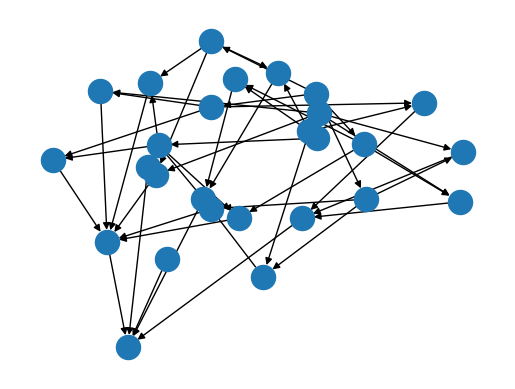

In [208]:
# Definim el sistema de regat

sistema_regat = ctrl.ControlSystem([regla1, regla2, regla3, regla4, regla5, regla6, regla7, regla8, regla9, regla10, regla11, regla12])

# Visualitzem el sistema de regat
sistema_regat.view()

## Definició del simulador del sistema de regat

A continuació, definirem el simulador del sistema de regat. Per a definir el simulador del sistema de regat, utilitzarem la funció `ctrl.ControlSystemSimulation` de la llibreria `skfuzzy`. Aquesta funció rep com a paràmetre el sistema de regat.


In [209]:
# Definim el simulador del sistema de regat

simulador_regat = ctrl.ControlSystemSimulation(sistema_regat)

## Simulació del sistema de regat

A continuació, simularem el sistema de regat.

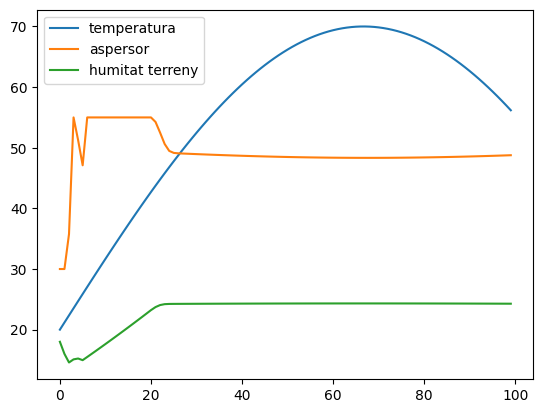

In [210]:
def controlador_difus(humitat_terreny_actual, temperatura):
    # Definim els antecedents del sistema de regat
    simulador_regat.input['humitat terreny (%)'] = humitat_terreny_actual
    simulador_regat.input['temperatura (ºC)'] = temperatura
    
    # Executem el sistema de regat
    try:
        simulador_regat.compute()
    except Exception as e:
        print("Humi. terreny: " + str(humitat_terreny_actual) + " Temp.: " + str(temperatura))
    
    # Retornem el valor de l'aspersor
    return simulador_regat.output['aspersor (%)']

simula_regat(controlador_difus, 20, 100)